In [1]:
# ===================================================================
# Cell 1: Setup and Imports
# ===================================================================
import pandas as pd
import numpy as np
import os
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# For iSOM Data Generation
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

# For TabPFN Model
from tabpfn import TabPFNClassifier
from sklearn.metrics import f1_score, accuracy_score

# --- Installation Note ---
# Make sure you have the necessary libraries installed:
# !pip install tabpfn minisom sklearn pandas seaborn matplotlib

print("Setup Complete!")

Setup Complete!


In [ ]:
# ===================================================================
# Cell 2: Interpretable SOM (iSOM) Synthetic Data Generator
# ===================================================================

def generate_isom_data(df_real, target_column, num_synthetic):
    """
    Generates synthetic data by training a SOM on real data and
    interpolating between neighboring nodes.
    """
    if num_synthetic == 0:
        return pd.DataFrame(columns=df_real.columns)

    print(f"Generating {num_synthetic} synthetic samples...")
    
    X_real = df_real.drop(columns=[target_column]).values
    y_real = df_real[target_column].values

    # Scale features for SOM training
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_real)

    # Train the SOM
    # The grid size can be tuned; 5*sqrt(N) is a common heuristic for total nodes
    map_size = int(np.sqrt(5 * np.sqrt(X_scaled.shape[0])))
    som_grid_size = (map_size, map_size)
    
    som = MiniSom(som_grid_size[0], som_grid_size[1], X_scaled.shape[1],
                  sigma=1.0, learning_rate=0.5, random_seed=42)
    som.random_weights_init(X_scaled)
    som.train_random(X_scaled, 1000)

    # Helper to find valid neighbors
    def get_neighbors(x, y, grid_size):
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size[0] and 0 <= ny < grid_size[1]:
                neighbors.append((nx, ny))
        return neighbors

    weights = som.get_weights()
    synthetic_samples = []
    rng = np.random.default_rng(42)

    for _ in tqdm(range(num_synthetic), desc="Generating iSOM data"):
        # Pick a random node
        x1, y1 = rng.integers(som_grid_size[0]), rng.integers(som_grid_size[1])
        
        # Find its neighbors and pick one
        valid_neighbors = get_neighbors(x1, y1, som_grid_size)
        if not valid_neighbors: continue
        x2, y2 = rng.choice(valid_neighbors)

        # Get weight vectors
        node1_weights = weights[x1, y1]
        node2_weights = weights[x2, y2]

        # Interpolate between the two nodes
        alpha = rng.random()
        new_sample_scaled = alpha * node1_weights + (1 - alpha) * node2_weights
        
        # Assign a target by finding the nearest real data point
        distances = np.linalg.norm(X_scaled - new_sample_scaled, axis=1)
        nearest_idx = np.argmin(distances)
        new_target = y_real[nearest_idx]

        synthetic_samples.append(np.append(new_sample_scaled, new_target))

    # Create a dataframe and inverse transform features
    synthetic_df = pd.DataFrame(synthetic_samples, columns=df_real.columns)
    synthetic_features_scaled = synthetic_df.drop(columns=[target_column]).values
    synthetic_features_orig = scaler.inverse_transform(synthetic_features_scaled)
    
    synthetic_df[df_real.drop(columns=[target_column]).columns] = synthetic_features_orig
    
    print("Synthetic data generation complete.")
    return synthetic_df

In [3]:
# ===================================================================
# Cell 3: Helper Functions
# ===================================================================

def read_data(path):
    _, ext = os.path.splitext(path)
    if ext == ".parquet":
        return pd.read_parquet(path)
    elif ext == ".csv":
        return pd.read_csv(path, index_col=0)

def load_data(base_path):
    """Load data from disk."""
    _, dataset_name = os.path.split(base_path)
    with open(os.path.join(base_path, f"{dataset_name}.meta.json")) as f:
        meta = json.load(f)
    format = meta["format"]
    train_data = read_data(os.path.join(base_path, f"{dataset_name}.{format}"))
    test_path = os.path.join(base_path, f"{dataset_name}_test.{format}")
    if os.path.exists(test_path):
        test_data = read_data(test_path)
    else:
        test_data = train_data
    return train_data, test_data, meta

def get_train_indices(base_path, repeats, train_fractions, full_train_size):
    """Generator for train/test splits based on fractions."""
    train_idx_file = os.path.join(base_path, "train_indices.parquet")
    train_idx_splits = pd.read_parquet(train_idx_file)

    for i in range(repeats):
        col_name = train_idx_splits.columns[i]
        split_indices = train_idx_splits[col_name].values
        
        for fraction in train_fractions:
            n_samples = int(fraction * full_train_size)
            info = {
                "repeat_idx": i,
                "train_fraction": fraction,
                "n_real_samples": n_samples,
            }
            yield info, split_indices[:n_samples]

In [4]:
# ===================================================================
# Cell 4: Experiment Configuration
# ===================================================================
# --- Main parameters to change ---
# NOTE: Your scripts expect data to be in a folder structure like:
# ./data/welded_beam/welded_beam.parquet
# ./data/welded_beam/welded_beam.meta.json
# ./data/welded_beam/train_indices.parquet
# ./data/welded_beam/welded_beam_test.parquet (optional)

BASE_DATA_PATH = "data" # Main folder containing all dataset folders
DATASET_NAME = "welded_beam" # The specific dataset folder to use

REPEATS = 5  # Number of times to repeat each fraction for statistical stability
TRAIN_FRACTIONS = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0] # Fractions of the original data to use

# --- Derived parameters ---
DATASET_PATH = os.path.join(BASE_DATA_PATH, DATASET_NAME)

if not os.path.exists(DATASET_PATH):
    raise ValueError(f"Dataset path not found: {DATASET_PATH}. Please check your folder structure.")

In [5]:
# ===================================================================
# Cell 5: Load Data and Prepare for Experiments
# ===================================================================

train_data, test_data, meta = load_data(DATASET_PATH)

X_columns = train_data.columns.drop(meta["label"])
y_column = meta["label"]

X_test = test_data[X_columns]
y_test = test_data[y_column]

full_train_size = len(train_data)
all_results = []

In [6]:
# ===================================================================
# Cell 6: Run Experiment A - Baseline (TabPFN on Original Data)
# ===================================================================

print("--- Starting Experiment A: Baseline ---")

classifier = TabPFNClassifier(device="cuda")

index_generator_a = get_train_indices(DATASET_PATH, REPEATS, TRAIN_FRACTIONS, full_train_size)

for info, train_indices in tqdm(index_generator_a, total=len(TRAIN_FRACTIONS) * REPEATS, desc="Baseline"):
    
    # Get the training subset
    X_train_subset = train_data.loc[train_indices, X_columns]
    y_train_subset = train_data.loc[train_indices, y_column]
    
    # Fit and predict
    start_time = time.time()
    classifier.fit(X_train_subset, y_train_subset)
    y_pred = classifier.predict(X_test)
    fit_time = time.time() - start_time
    
    # Score and store results
    score = f1_score(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)
    
    result = {**info, "experiment": "Baseline", "f1_score": score, "accuracy": acc, "fit_time": fit_time}
    all_results.append(result)

print("--- Experiment A Complete ---")

--- Starting Experiment A: Baseline ---


Baseline:   0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\johnn\Documents\From Desktop\All things Python\env\lib\site-packages\tabpfn\architectures\base\attention\full_attention.py:678: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attention_head_outputs = torch.nn.functional.scaled_dot_product_attention(


--- Experiment A Complete ---


In [7]:
# ===================================================================
# Cell 7: Run Experiment B - iSOM Augmented Data
# ===================================================================

print("\n--- Starting Experiment B: iSOM Augmentation ---")

index_generator_b = get_train_indices(DATASET_PATH, REPEATS, TRAIN_FRACTIONS, full_train_size)

for info, train_indices in tqdm(index_generator_b, total=len(TRAIN_FRACTIONS) * REPEATS, desc="Augmented"):
    
    # Your core idea: use a fraction of real data, but augment it to the full dataset size
    if info['train_fraction'] < 1.0:
        # Get the real data subset
        train_subset_real = train_data.loc[train_indices]
        
        # Calculate how much synthetic data to generate
        num_synthetic = full_train_size - len(train_subset_real)
        
        # Generate synthetic data based ONLY on the real subset
        train_subset_synthetic = generate_isom_data(train_subset_real, y_column, num_synthetic)
        
        # Combine real and synthetic data for training
        train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)
        
    else: # If fraction is 1.0, no augmentation is needed
        train_augmented = train_data.loc[train_indices]

    X_train_augmented = train_augmented[X_columns]
    y_train_augmented = train_augmented[y_column]
    
    # Fit and predict
    start_time = time.time()
    classifier.fit(X_train_augmented, y_train_augmented)
    y_pred = classifier.predict(X_test)
    fit_time = time.time() - start_time

    # Score and store results
    score = f1_score(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)

    result = {**info, "experiment": "iSOM Augmented", "f1_score": score, "accuracy": acc, "fit_time": fit_time}
    all_results.append(result)

print("--- Experiment B Complete ---")


--- Starting Experiment B: iSOM Augmentation ---


Augmented:   0%|          | 0/30 [00:00<?, ?it/s]

Generating 1800 synthetic samples from a base of 200 real samples...
Generating 1600 synthetic samples from a base of 400 real samples...
Generating 1200 synthetic samples from a base of 800 real samples...
Generating 800 synthetic samples from a base of 1200 real samples...
Generating 400 synthetic samples from a base of 1600 real samples...
Generating 1800 synthetic samples from a base of 200 real samples...
Generating 1600 synthetic samples from a base of 400 real samples...
Generating 1200 synthetic samples from a base of 800 real samples...
Generating 800 synthetic samples from a base of 1200 real samples...
Generating 400 synthetic samples from a base of 1600 real samples...
Generating 1800 synthetic samples from a base of 200 real samples...
Generating 1600 synthetic samples from a base of 400 real samples...
Generating 1200 synthetic samples from a base of 800 real samples...
Generating 800 synthetic samples from a base of 1200 real samples...
Generating 400 synthetic samples f

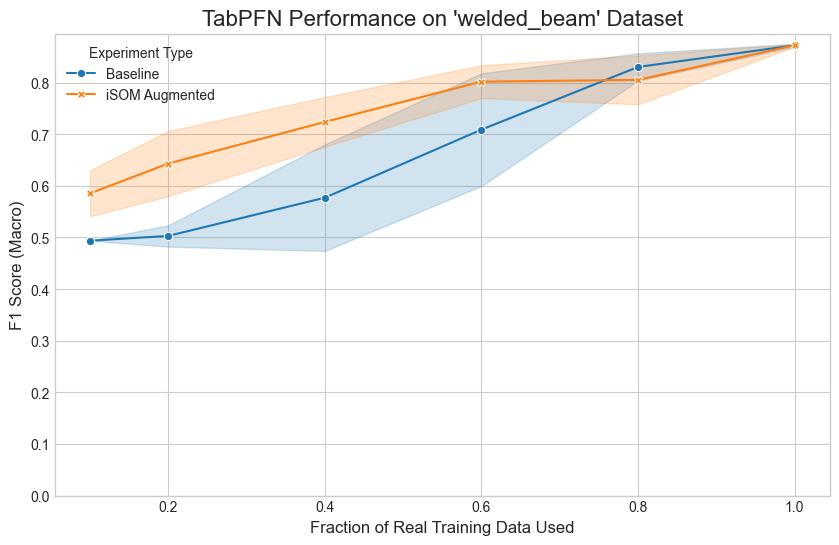

In [8]:
# ===================================================================
# Cell 8: Analyze and Visualize Results
# ===================================================================

results_df = pd.DataFrame(all_results)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=results_df,
    x="train_fraction",
    y="f1_score",
    hue="experiment",
    style="experiment",
    markers=True,
    dashes=False,
    ax=ax,
    errorbar="sd" # Show standard deviation as error bars
)

ax.set_title(f"TabPFN Performance on '{DATASET_NAME}' Dataset", fontsize=16)
ax.set_xlabel("Fraction of Real Training Data Used", fontsize=12)
ax.set_ylabel("F1 Score (Macro)", fontsize=12)
ax.legend(title="Experiment Type")
ax.set_ylim(bottom=0) # F1 score cannot be negative

plt.show()